In [1]:
# Adapted from https://temugeb.github.io/opencv/python/2021/02/02/stereo-camera-calibration-and-triangulation.html
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

# parameters
ch_rows = 6  # rows of checkerboard
ch_cols = 9  # columns of checkerboard
square_size = 0.010 # 10mm x 10mm

def deep_copy_images(images):
    return [image.copy() for image in images]

def readImages(im_array,dir_path):
    filenames = os.listdir(dir_path)
    for filename in filenames:
        im = cv.imread(dir_path+os.path.sep+filename, 1)
        im_array.append(im)

def calibrate_camera(images_, camera_name):
    images = deep_copy_images(images_) #to prevent drawing on the original images

    print('-> Calibrating camera: ', camera_name)
    corner_detection_param = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001) #criteria

    im_width = images[0].shape[1]
    im_height = images[0].shape[0]

    # Corners in checkerboard space
    corners_ch = np.zeros((ch_rows*ch_cols,3), np.float32)
    corners_ch[:,:2] = np.mgrid[0:ch_cols,0:ch_rows].T.reshape(-1,2) * square_size

    # Corners in image space
    corners_img = []

    # Coordinates of corners in 3D space
    corners_3d = []

    for img in images:
        gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        ret, corners = cv.findChessboardCorners(gray, (ch_cols,ch_rows),None)
        if ret == True:
            corners = cv.cornerSubPix(gray,corners,(11,11),(-1,-1),corner_detection_param) #improves corner accuracy
            #cv.drawChessboardCorners(img, (ch_cols,ch_rows), corners,ret)
            #cv.imshow('img', img)
            #k = cv.waitKey(500)
            corners_img.append(corners)
            corners_3d.append(corners_ch)

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(corners_3d, corners_img, (im_width,im_height),None,None)
    print('\tCalibration metrics for camera: ', camera_name)
    print('\trmse:', ret)
    #print('camera matrix:\n', mtx)
    #print('distortion coeffs:', dist)
    # print('Rs:\n', rvecs)
    # print('Ts:\n', tvecs)
    return mtx, dist, corners_img, corners_3d

def stereo_calibrate(mtx1, dist1, mtx2, dist2, images1_, images2_, camera_name1, camera_name2):
    images1 = deep_copy_images(images1_) #to prevent drawing on the original images
    images2 = deep_copy_images(images2_) #to prevent drawing on the original images

    print('-> Calibrating stereo cameras ' + camera_name1 + ' and ' + camera_name2)
    #change this if stereo calibration not good.
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.0001)

    #coordinates of squares in the checkerboard world space
    objp = np.zeros((ch_rows*ch_cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:ch_rows,0:ch_cols].T.reshape(-1,2)

    #frame dimensions. Frames should be the same size.
    width = images1[0].shape[1]
    height = images1[0].shape[0]

    #Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []

    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space

    for frame1, frame2 in zip(images1, images2):
        gray1 = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
        c_ret1, corners1 = cv.findChessboardCorners(gray1, (ch_rows, ch_cols),None)
        c_ret2, corners2 = cv.findChessboardCorners(gray2, (ch_rows, ch_cols),None)

        if c_ret1 == True and c_ret2 == True:
            corners1 = cv.cornerSubPix(gray1,corners1,(11,11),(-1,-1),criteria)
            corners2 = cv.cornerSubPix(gray2,corners2,(11,11),(-1,-1),criteria)
            # # Show the corners to check if they are correct
            # cv.drawChessboardCorners(frame1, (ch_rows,ch_cols), corners1,c_ret1)
            # cv.imshow('img', frame1)
            # k = cv.waitKey(500)
            # cv.drawChessboardCorners(frame2, (ch_rows,ch_cols), corners2,c_ret2)
            # cv.imshow('img', frame2)
            # k = cv.waitKey(500)
            objpoints.append(objp)
            imgpoints_left.append(corners1)
            imgpoints_right.append(corners2)

    stereocalibration_flags = cv.CALIB_FIX_INTRINSIC
    ret, CM1, dist1, CM2, dist2, R, T, E, F = cv.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1,
                                                                 mtx2, dist2, (width, height), criteria=criteria, flags=stereocalibration_flags)
    print('\tStereo calibration metrics:')
    print('\trmse:', ret)
    return R, T


# Load images from the "Calibration 1/calibration.." folder
left_images, middle_images, right_images = [], [], []
readImages(left_images,'Calibratie 1'+os.path.sep+'calibrationLeft')
readImages(middle_images,'Calibratie 1'+os.path.sep+'calibrationMiddle')
readImages(right_images,'Calibratie 1'+os.path.sep+'calibrationRight')

mtx_left, dist_left, corners_img_left, corners_3d_left = calibrate_camera(left_images, 'left')
mtx_middle, dist_middle, corners_img_middle, corners_3d_middle = calibrate_camera(middle_images, 'middle')
mtx_right, dist_right, corners_img_right, corners_3d_right = calibrate_camera(right_images, 'right')

R_lm, T_lm = stereo_calibrate(mtx_left, dist_left, mtx_middle, dist_middle, left_images, middle_images, 'left', 'middle')
R_mr, T_mr = stereo_calibrate(mtx_middle, dist_middle, mtx_right, dist_right, middle_images, right_images, 'middle', 'right')

#TODO: Next we need perform stereo rectification on the images, i think we could use the cv.stereoRectify function for this.

def stereo_rectify(mtx1, dist1, mtx2, dist2, R, T, width, height):
    # Compute the rectification transformations
    R1, R2, P1, P2, Q, validPixROI1, validPixROI2 = cv.stereoRectify(
        mtx1, dist1, mtx2, dist2, (width, height), R, T)
    # Generate rectification maps for each camera
    map1x, map1y = cv.initUndistortRectifyMap(mtx1, dist1, R1, P1, (width, height), cv.CV_32FC1)
    map2x, map2y = cv.initUndistortRectifyMap(mtx2, dist2, R2, P2, (width, height), cv.CV_32FC1)

    return R1, R2, P1, P2, Q, map1x, map1y, map2x, map2y

width = left_images[0].shape[1]
height = left_images[0].shape[0]

# Call stereo_rectify function for left and middle cameras
R1_lm, R2_lm, P1_lm, P2_lm, Q_lm, map1x_lm, map1y_lm, map2x_lm, map2y_lm = stereo_rectify(mtx_left, dist_left, mtx_middle, dist_middle, R_lm, T_lm, width, height)
# Call stereo_rectify function for middle and right cameras
R1_mr, R2_mr, P1_mr, P2_mr, Q_mr, map1x_mr, map1y_mr, map2x_mr, map2y_mr = stereo_rectify(mtx_middle, dist_middle, mtx_right, dist_right, R_mr, T_mr, width, height)

# Rectify a pair of images (e.g., left and middle images)
def rectify_images(image1, image2, map1x, map1y, map2x, map2y):
    # Apply rectification maps to the images
    rectified_image1 = cv.remap(image1, map1x, map1y, interpolation=cv.INTER_LINEAR)
    rectified_image2 = cv.remap(image2, map2x, map2y, interpolation=cv.INTER_LINEAR)
    return rectified_image1, rectified_image2


-> Calibrating camera:  left
	Calibration metrics for camera:  left
	rmse: 0.09691601166552825
-> Calibrating camera:  middle
	Calibration metrics for camera:  middle
	rmse: 0.10070843178758267
-> Calibrating camera:  right
	Calibration metrics for camera:  right
	rmse: 0.08761552078960229
-> Calibrating stereo cameras left and middle
	Stereo calibration metrics:
	rmse: 0.6937413602067044
-> Calibrating stereo cameras middle and right
	Stereo calibration metrics:
	rmse: 0.147972259767422


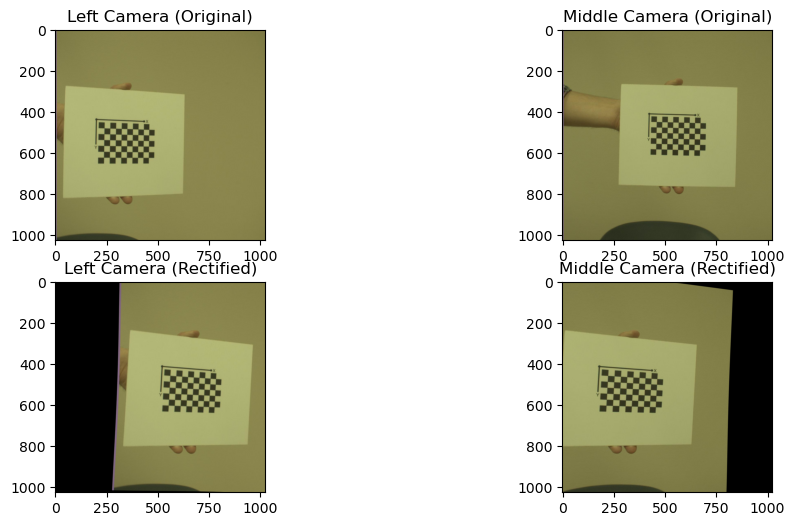

In [2]:
# Choose an image pair for rectification (e.g., the first pair from your datasets)
image_index = 0
rectified_left, rectified_middle = rectify_images(left_images[image_index], middle_images[image_index], map1x_lm, map1y_lm, map2x_lm, map2y_lm)

# Plot the original and rectified images
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(cv.cvtColor(left_images[image_index], cv.COLOR_BGR2RGB))
plt.title('Left Camera (Original)')
plt.subplot(2, 2, 2)
plt.imshow(cv.cvtColor(middle_images[image_index], cv.COLOR_BGR2RGB))
plt.title('Middle Camera (Original)')
plt.subplot(2, 2, 3)
plt.imshow(cv.cvtColor(rectified_left, cv.COLOR_BGR2RGB))
plt.title('Left Camera (Rectified)')
plt.subplot(2, 2, 4)
plt.imshow(cv.cvtColor(rectified_middle, cv.COLOR_BGR2RGB))
plt.title('Middle Camera (Rectified)')
plt.show()

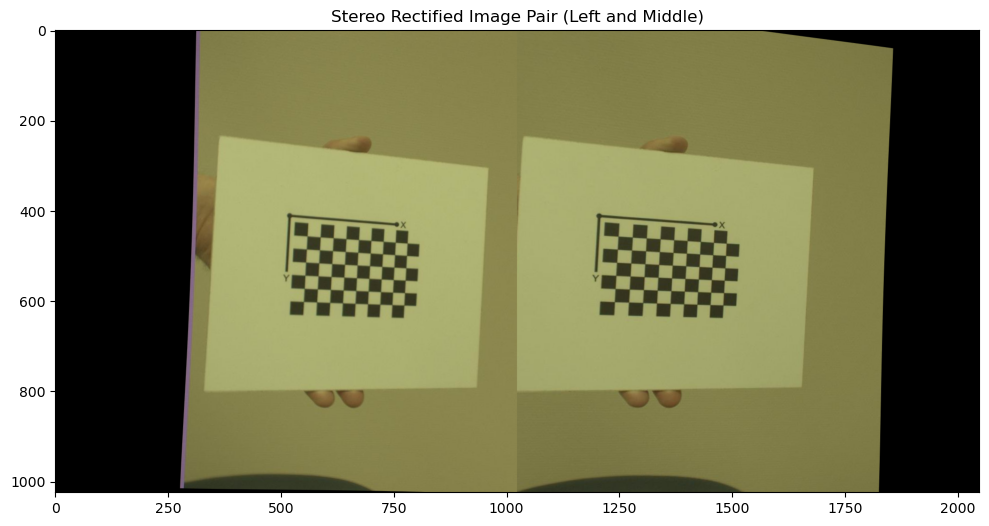

In [3]:
# Combine the rectified images into a single composite image
composite_image = cv.hconcat([rectified_left, rectified_middle])

# Display the composite image
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(composite_image, cv.COLOR_BGR2RGB))
plt.title('Stereo Rectified Image Pair (Left and Middle)')
plt.show()